## how often to genes in clusters share funciton?

inspired by https://www.nature.com/articles/s41467-021-25129-x, "The molecular basis, genetic control and pleiotropic effects of local gene co-expression", espeically figure 3 and go term enrishment analysis and https://www.nature.com/articles/s42003-022-03831-w "Shared regulation and functional relevance of local gene co-expression revealed by single cell analysis" go term enrichment analysis

* distance in groups vs not X
* paralog frequency X 
* bidirecitonal promotors X
* shared enhancers X 
* shared go term
* same pathway
* same complex 
* inverted/total ctcf motifs between
* hi-c contacts? (from abc data?)
* cross mappability X

I want to make some plots here, and also add all of these annotations to the cluster file. At a later point, perhaps automate the annotation of the clusters file with this information

In [57]:
import numpy as np
import pandas as pd
import scipy as sp
from tqdm.auto import tqdm  # for notebooks
tqdm.pandas()

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import scipy.stats as stats
from sklearn.linear_model import LinearRegression
import math
import upsetplot as up
import ast
import os
import statsmodels as sm

import sys
sys.path.append('/home/klawren/oak/pcqtls/workflow/scripts')
from residualize import calculate_residual
import annotate_clusters

# get outputs from a config file
prefix = '/home/klawren/oak/pcqtls'
import yaml
config_path= f'{prefix}/config/proteincoding_main.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

tissue_id_path = config['tissue_id_path']
clusters_dir = config['clusters_dir']
expression_dir = config['expression_dir']
covariates_dir = config['covariates_dir']


# load in the tissue ids 
tissue_df = pd.read_csv(f"{prefix}/{tissue_id_path}", header=0)
tissue_ids = list(tissue_df['Tissue'])
my_tissue_id = 'Nerve_Tibial'

protien_coding_only = True

In [11]:
load_all_tissues = False

## load in data
cluster df, expression df, gencode

In [12]:
# load in gene data
full_gencode=pd.read_csv(f'{prefix}/data/references/processed_gencode.v26.GRCh38.genes.csv')


# filter to protien coding
if protien_coding_only:
    non_protein_gencode = full_gencode.copy()
    full_gencode = full_gencode[full_gencode['gene_type'] == 'protein_coding']

gid_gencode = full_gencode.set_index('transcript_id').drop_duplicates()

In [13]:
# load in cluster data for a single tissue
cluster_df = pd.read_csv(f'{prefix}/{clusters_dir}/{my_tissue_id}_clusters_all_chr.csv', index_col=0)

# load in cluster data for all tissues
if load_all_tissues:
    all_tissue_cluster_dfs={}
    for tissue_id in tissue_ids: 
        all_tissue_cluster_dfs[tissue_id] = pd.read_csv(f'{prefix}/{clusters_dir}/{tissue_id}_clusters_all_chr.csv', index_col=0)

# load in expression data (so we only compare to pairs of genes also expressed in this tissue)
# load in gene expression data
expression_df = pd.read_csv(f'{prefix}/{expression_dir}/{my_tissue_id}.v8.normalized_expression.bed', sep='\t')

# load in expression data for all tissues 
if load_all_tissues:
    all_tissue_expression_dfs={}
    for tissue_id in tissue_ids: 
        all_tissue_expression_dfs[tissue_id] = pd.read_csv(f'{prefix}/{expression_dir}/{tissue_id}.v8.normalized_expression.bed', sep='\t')

# expressed genes in sample tissue
expressed_gencode = full_gencode[full_gencode['transcript_id'].isin(expression_df['gene_id'])]
expressed_gencode = expressed_gencode.sort_values(['chr', 'start', 'end'])


# expressed genes in all tissues
if load_all_tissues:
    all_tissue_expressed_gencode_dfs={}
    for tissue_id in tissue_ids: 
        expressed_gencode = full_gencode[full_gencode['transcript_id'].isin(all_tissue_expression_dfs[tissue_id]['gene_id'])]
        expressed_gencode = expressed_gencode.sort_values(['chr', 'start', 'end'])
        all_tissue_expressed_gencode_dfs[tissue_id] = expressed_gencode

In [14]:
# residulized expression for correlations
covariates_df = pd.read_csv(f'{prefix}/{covariates_dir}/{my_tissue_id}.v8.covariates.txt', sep='\t', index_col=0).T
gid_expression = expression_df.set_index('gene_id')[covariates_df.index]
residal_exp = calculate_residual(gid_expression[covariates_df.index], covariates_df, center=True)
residal_exp = pd.DataFrame(residal_exp, columns=covariates_df.index, index=gid_expression.index)

In [58]:
# load in ABC data for enhancer gene connections
full_abc_pred_df = pd.read_csv(f'{prefix}/data/references/functional_annotations/ABC_predictions/AllPredictions.AvgHiC.ABC0.015.minus150.ForABCPaperV3.txt.gz', sep='\t')

# load in tissue matching for ABC-gtex tissues
# this has to be done by hand
# some were clear, for those that aren't I've asked for help and put None for now

abc_gtex_match = pd.read_csv(f'{prefix}/data/references/functional_annotations/ABC_predictions/ABC_matched_gtex.csv')

# get just the enhancer-gene connections for the matched tissue
abc_df = full_abc_pred_df[full_abc_pred_df['CellType'] == abc_gtex_match[abc_gtex_match['GTEX_tissue'] == my_tissue_id]['ABC_biosample_id'].iloc[0]]

# add transcript ids to relevant abc enhancer-gene connection columns these and set as index
gene_enhancer_df = pd.merge(full_gencode[['transcript_id', 'gene_name']], abc_df[['TargetGene','name','class', 'ABC.Score']], left_on='gene_name', right_on='TargetGene', how='left')
gene_enhancer_df.rename(columns={'name':'enhancer'}, inplace=True)
gene_enhancer_df.set_index('transcript_id', inplace=True)
gene_enhancer_df.dropna(inplace=True)

In [16]:
# load in ctcf data
ctcf_gtex_match = pd.read_csv(f'{prefix}/data/references/functional_annotations/ctcf_chip/ctcf_matched_gtex.csv')
ctcf_file = ctcf_gtex_match[ctcf_gtex_match['GTEX'] == my_tissue_id].iloc[0]['ctcf']
ctcf_df = pd.read_csv(f'{prefix}/data/references/functional_annotations/ctcf_chip/{ctcf_file}.bed.gz', sep='\t', 
                      names=['chr', 'start', 'end', 'name', 'score', 'strand', 'signal_value', 'p_value', 'q_value', 'peak'])
ctcf_df['peak_inter'] = pd.arrays.IntervalArray.from_arrays(ctcf_df['start'], ctcf_df['end'])
ctcf_df['point_inter'] = pd.arrays.IntervalArray.from_arrays(ctcf_df['start'] + ctcf_df['peak'], ctcf_df['start'] + ctcf_df['peak'] + 1)
ctcf_df['Chromosome'] = ctcf_df['chr'].str.split('chr').str[1].astype(str)

In [17]:
# load in paralogs
paralog_df = pd.read_csv(f'{prefix}/data/references/functional_annotations/paralogs_biomart_ensembl97.tsv.gz', sep='\t')

# drop genes that don't have paralogues
paralog_df.dropna(subset=['Human paralogue gene stable ID'], inplace=True)

# group by the gene that has the paralogs (this is bidirectional)
# this needs to be done on gene ids without versions, as this isn't the same version number (sadly the correct version isn't availble on biomart)
paralog_df = paralog_df.groupby('Gene stable ID')['Human paralogue gene stable ID'].apply(set)

In [18]:
# load in go terms
go_df = pd.read_csv(f'{prefix}/data/references/functional_annotations/go_biomart_ensembl97.tsv.gz', sep='\t', header=None,
                    names = ['Gene stable ID', 'Gene stable ID version', 'Gene start (bp)', 'Gene end', 'Strand', 'tss', 'gencode_annotation', 'gene_name', 'transcript_type', 'go_accession', 'go_name', 'go_domain'])

# only consider matching biological process go terms, as in Ribiero 2021
go_df = go_df[go_df['go_domain'] == 'biological_process'].groupby('Gene stable ID')['go_accession'].apply(set)

In [19]:
# load in cross mapablity (this is cleaned up in cross_mappability.ipynb)
cross_mappability = pd.read_csv(f'{prefix}/data/references/cross_mappability/cross_mappability_100_agg.csv')
cross_mappability.set_index('gene_1', inplace=True)

In [20]:
# load in complexes
complex_df = pd.read_csv('/home/klawren/oak/pcqtls/data/references/functional_annotations/humancomplexes_corum4.1.txt', sep='\t')

# add ensemble IDs based on gene names, to end with a ensemble ID indexed list of complexes
complex_df['all_subunits'] = complex_df['subunits(Gene name syn)'].astype(str) +  ';' + complex_df['subunits(Gene name)'].astype(str)
complex_df['all_subunit_gene_names'] = complex_df['all_subunits'].str.split(';| ')
complex_df = full_gencode[['transcript_id', 'gene_name']].join(complex_df.explode('all_subunit_gene_names').groupby('all_subunit_gene_names').agg({'ComplexID':set}), on='gene_name')
complex_df.set_index('transcript_id', inplace=True)
complex_df.drop('gene_name', inplace=True, axis=1)
complex_df.dropna(inplace=True)


## annotation functions for clusters

#### bidirectional promotors
if two of the genes in the cluster are opposite strand with tss < 1000 bp away, classify as bidirecitonal promotor

#### Enhancer sharing 

ABC for 131 biosmaples (could probably find matches for most of mine) from Nasser et al. Nature (2021): Genome-wide enhancer maps connect risk variants to disease genes. (download link: https://www.engreitzlab.org/resources) copied from /oak/stanford/groups/engreitz/public/Nasser2021

#### GO term sharing, paralogs

downloaded all go terms, paralogs for ensemble IDs from biomart

In [21]:
# add cluster size from gene-gene into cluster df
def get_cluster_size(row):
    transcript_ids = row['Transcripts'].split(',')
    cluster_gencode = gid_gencode.loc[transcript_ids]
    return  cluster_gencode['end'].max() - cluster_gencode['start'].min()

def get_cluster_tss_size(row):
    transcript_ids = row['Transcripts'].split(',')
    cluster_gencode = gid_gencode.loc[transcript_ids]
    return  cluster_gencode['tss_start'].max() - cluster_gencode['tss_start'].min()

def get_cluster_start_ids(cluster_df):
    # the first for pairs, the first and second for threes, ect
    cluster_start_ids = []
    for i in range(cluster_df['N_genes'].max()):
        out_ids = cluster_df[cluster_df['N_genes'] == i]['Transcripts'].str.split(',').str[:i-1].values
        if len(out_ids)>0:
            cluster_start_ids.append(np.concatenate(out_ids))
        else:
            cluster_start_ids.append([])
    return cluster_start_ids

def annotate_sizes(cluster_df):
    cluster_df['cluster_size'] = cluster_df.progress_apply(get_cluster_size, axis=1)
    cluster_df['cluster_tss_size'] = cluster_df.progress_apply(get_cluster_tss_size, axis=1)

def annotate_positions(cluster_df):
    for idx, row in cluster_df.iterrows():
        transcript_ids = row['Transcripts'].split(',')
        cluster_gencode = gid_gencode.loc[transcript_ids]
        cluster_df.loc[idx, 'start'] = cluster_gencode['start'].min()
        cluster_df.loc[idx, 'end'] = cluster_gencode['end'].max()

In [22]:
def get_bidirectional(row, gid_gencode):
    transcript_ids = row['Transcripts'].split(',')
    cluster_gencode = gid_gencode.loc[transcript_ids]
    num_bidirectional = 0
    # check all pairwise combos of genes
    for idx, first_gene_row in cluster_gencode.iterrows():
        for idx, second_gene_row in cluster_gencode.iterrows():
            opp_strand = first_gene_row['strand'] != second_gene_row['strand']
            close = abs(first_gene_row['tss_start'] - second_gene_row['tss_start']) <= 1000
            if opp_strand & close:
                # found a bidirectional promotor
                num_bidirectional +=1

    # didn't find a bidirectional promotor
    return num_bidirectional/2

def annotate_bidirectional(cluster_df, gid_gencode):
    cluster_df['num_bidirectional_promoter'] = cluster_df.progress_apply(get_bidirectional, axis=1, args=(gid_gencode,))
    cluster_df['has_bidirectional_promoter'] = cluster_df['num_bidirectional_promoter'] > 0



In [23]:
# annotate clusters with the number of shared enhancers

def annotate_enhancers(cluster_df, gene_enhancer_df):
    for idx, row in tqdm(cluster_df.iterrows(), total=len(cluster_df)):
        enhancer_list = gene_enhancer_df[gene_enhancer_df.index.isin(row['Transcripts'].split(','))]
        full_enhancer_list = enhancer_list['enhancer']
        strong_enhancer_list = enhancer_list[enhancer_list['ABC.Score']>=0.1]['enhancer']
        very_strong_enhancer_list = enhancer_list[enhancer_list['ABC.Score']>=0.25]['enhancer']

        num_shared_enhancers = sum(full_enhancer_list.duplicated())
        num_shared_strong_enhancers = sum(strong_enhancer_list.duplicated())
        num_shared_very_strong_enhancers = sum(very_strong_enhancer_list.duplicated())


        cluster_df.loc[idx, 'num_shared_enhancers'] = num_shared_enhancers
        cluster_df.loc[idx, 'num_shared_strong_enhancers'] = num_shared_strong_enhancers
        cluster_df.loc[idx, 'num_enhancers'] = len(full_enhancer_list)
        cluster_df.loc[idx, 'num_strong_enhancers'] = len(strong_enhancer_list)
        cluster_df.loc[idx, 'has_shared_enhancer'] = num_shared_enhancers > 0
        cluster_df.loc[idx, 'has_shared_strong_enhancer'] = num_shared_strong_enhancers > 0
        cluster_df.loc[idx, 'has_shared_very_strong_enhancer'] = num_shared_very_strong_enhancers > 0

In [24]:
def annotate_ctcf(cluster_df, ctcf_df):
    annotate_positions(cluster_df)
    cluster_df['interval'] = pd.arrays.IntervalArray.from_arrays(cluster_df['start'], cluster_df['end'])

    # ctcf intervals for each chromosome
    chr_ctcf_peaks={}
    chr_ctcf_points={}

    for chr in cluster_df['Chromosome'].unique():
        ctcf_chr = ctcf_df[ctcf_df['Chromosome'] == chr.astype(str)]
        chr_ctcf_peaks[chr] = pd.arrays.IntervalArray.from_arrays(ctcf_chr['start'], ctcf_chr['end'])
        chr_ctcf_points[chr] = pd.arrays.IntervalArray.from_arrays(ctcf_chr['start'] + ctcf_chr['peak'], ctcf_chr['start'] + ctcf_chr['peak'] + 1)


    # annotate each cluster
    for idx, row in tqdm(cluster_df.iterrows(), total=len(cluster_df)):
        num_ctcf_peak = sum(chr_ctcf_peaks[row['Chromosome']].overlaps(row['interval']))
        num_ctcf_point = sum(chr_ctcf_points[row['Chromosome']].overlaps(row['interval']))

        cluster_df.loc[idx, 'num_ctcf_peak'] = num_ctcf_peak
        cluster_df.loc[idx, 'has_ctcf_peak'] = num_ctcf_peak > 0
        cluster_df.loc[idx, 'num_ctcf_point'] = num_ctcf_point
        cluster_df.loc[idx, 'has_ctcf_point'] = num_ctcf_point > 0



In [56]:

def annotate_enhancers_jaccard(cluster_df, gene_enhancer_df):
    for idx, row in tqdm(cluster_df.iterrows(), total=len(cluster_df)):
        transcript_list = row['Transcripts'].split(',')
        jaccards_unweighted=[]
        jaccards_weighted=[]
        for i in range(len(transcript_list)):
            for j in range(i):
                enhancer_list = gene_enhancer_df[gene_enhancer_df.index.isin([transcript_list[i], transcript_list[j]])]
                enhancer_list['ABC.Score_min'] = enhancer_list['ABC.Score']
                enhancer_min_max = enhancer_list.groupby('enhancer').agg({'ABC.Score':'max', 'ABC.Score_min':'min'})

                # zero out the mins for those elements that exist for only 1 gene
                enhancer_gene_counts = enhancer_list.groupby('enhancer').agg({'gene_name':'nunique'}) 
                single_enhancers = enhancer_gene_counts.index.values[enhancer_gene_counts['gene_name'] == 1]
                enhancer_min_max.loc[single_enhancers, 'ABC.Score_min'] = 0
                # jaccard without reweighting
                jaccards_unweighted.append(enhancer_min_max['ABC.Score_min'].sum()/enhancer_min_max['ABC.Score'].sum())
                # assuming these don't sum to 1 for a given gene becuase the promoter-self connections aren't listed
                # add in an element for each genes promotor to get the final weighting right
                reweightings = enhancer_list.groupby('gene_name').agg({'ABC.Score':sum})
                reweightings['ABC.Score'] = 1- reweightings['ABC.Score']
                reweightings['ABC.Score_min'] = 0

                enhancer_min_max = pd.concat([enhancer_min_max, reweightings])
                # jaccard with reweighting
                jaccards_weighted.append(enhancer_min_max['ABC.Score_min'].sum()/enhancer_min_max['ABC.Score'].sum())

        # if there aren't any enhancers, return nan
        # for clusters larger than pairs, one option is to filter out the nans
        #jaccards_unweighted = np.asarray(jaccards_unweighted)
        #jaccards_unweighted = jaccards_unweighted[~np.isnan(jaccards_unweighted)]
        #jaccards_weighted = np.asarray(jaccards_weighted)
        #jaccards_weighted = jaccards_weighted[~np.isnan(jaccards_weighted)]

        # instead, I just mask the nans to 0
        jaccards_weighted = np.nan_to_num(jaccards_weighted)
        jaccards_unweighted = np.nan_to_num(jaccards_unweighted)


        cluster_df.loc[idx, 'max_jaccard_unweighted'] = max(jaccards_unweighted)
        cluster_df.loc[idx, 'max_jaccard_weighted'] = max(jaccards_weighted)
        cluster_df.loc[idx, 'has_high_jaccard_unweighted'] = max(jaccards_unweighted) > 0.5
        cluster_df.loc[idx, 'has_high_jaccard_weighted'] = max(jaccards_weighted) > 0.1
        cluster_df.loc[idx, 'mean_jaccard_unweighted'] = np.average(jaccards_unweighted)
        cluster_df.loc[idx, 'mean_jaccard_weighted'] = np.average(jaccards_weighted)


In [17]:
def annotate_correlation(cluster_df, residal_exp):
    for idx, row in tqdm(cluster_df.iterrows(), total=len(cluster_df)):
        transcript_list = row['Transcripts'].split(',')
        cluster_expression = residal_exp.loc[transcript_list].T.corr('spearman').to_numpy()
        cluster_corr = cluster_expression[np.triu_indices(len(cluster_expression), k=1)]
        cluster_df.loc[idx, 'Mean_cor'] = cluster_corr.mean()
        cluster_df.loc[idx, 'Mean_pos_cor'] = cluster_corr[cluster_corr>0].mean()
        cluster_df.loc[idx, 'Mean_neg_cor'] = cluster_corr[cluster_corr<0].mean()


In [18]:
def annotate_go(cluster_df, go_df):
    for idx, row in tqdm(cluster_df.iterrows(), total=len(cluster_df)):
        transcript_list_versions = row['Transcripts'].split(',')
        transcript_list_no_versions = [transcript.split('.')[0] for transcript in transcript_list_versions]

        go_list = go_df[go_df.index.isin(transcript_list_no_versions)]
        num_shared_go_all = sum(go_list.duplicated())
        # number genes that share all their go terms with another gene
        cluster_df.loc[idx, 'num_shared_go_all'] = num_shared_go_all
        cluster_df.loc[idx, 'has_shared_go_all'] = num_shared_go_all > 0

        # number go terms shared between any genes
        num_shared_go_any = sum(go_list.explode().duplicated())
        cluster_df.loc[idx, 'num_shared_go_any'] = num_shared_go_any
        cluster_df.loc[idx, 'has_shared_go_any'] = num_shared_go_any > 0


In [19]:
def annotate_complexes(cluster_df, complex_df):
    for idx, row in tqdm(cluster_df.iterrows(), total=len(cluster_df)):
        complex_list = complex_df[complex_df.index.isin(row['Transcripts'].split(','))]
        num_complexes = sum(complex_list.explode('ComplexID').duplicated())
        cluster_df.loc[idx, 'num_complexes'] = num_complexes
        cluster_df.loc[idx, 'has_complexes'] = num_complexes > 0

In [20]:
# annotate paralogs
def get_paralogs(row, paralog_df):
    transcript_list_versions = row['Transcripts'].split(',')
    transcript_list_no_versions = set([transcript.split('.')[0] for transcript in transcript_list_versions])

    paralogs = 0
    for transcript in transcript_list_no_versions:
        try:
            has_paralog = bool(paralog_df.loc[transcript] & transcript_list_no_versions)
            paralogs += has_paralog
        except KeyError:
            # if this isn't in the paralog df, it has no paralogs, so continue
            pass
    return paralogs

def annotate_paralogs(cluster_df, paralog_df):
    cluster_df['num_paralog'] = cluster_df.progress_apply(get_paralogs, axis=1, args=(paralog_df,))
    cluster_df['has_paralog'] = cluster_df['num_paralog'] > 0


In [21]:
def get_cross_map(row, cross_mappability, cross_map_threshold=100):
    # number of transcripts that cross map to some other transcript in the cluster
    transcript_list = set(row['Transcripts'].split(','))
    cross_maps = 0
    for transcript in transcript_list:
        try:
            cross_map_this_transcript = cross_mappability.loc[transcript]
            pass_threshold_mask = np.asarray(ast.literal_eval(cross_map_this_transcript['cross_mappability'])) > cross_map_threshold
            cross_map_this_transcript = np.asarray(ast.literal_eval(cross_map_this_transcript['gene_2_full']))[pass_threshold_mask]
            has_cross_map = bool(set(cross_map_this_transcript) & transcript_list)
            cross_maps += has_cross_map
        except KeyError:
            # if this isn't in the paralog df, it has no paralogs, so continue
            pass
    return cross_maps

def annotate_cross_maps(cluster_df, cross_mappability):
    cluster_df['num_cross_map'] = cluster_df.progress_apply(get_cross_map, axis=1, args=(cross_mappability,))
    cluster_df['has_cross_map'] = cluster_df['num_cross_map'] > 0

### annotate a cluster df

In [22]:
def add_annotations(cluster_df):
    annotate_sizes(cluster_df)
    annotate_bidirectional(cluster_df, gid_gencode)
    annotate_enhancers(cluster_df, gene_enhancer_df)
    annotate_paralogs(cluster_df, paralog_df)
    annotate_cross_maps(cluster_df,cross_mappability)
    annotate_go(cluster_df, go_df)
    annotate_complexes(cluster_df, complex_df)
    annotate_enhancers_jaccard(cluster_df, gene_enhancer_df)
    annotate_ctcf(cluster_df, ctcf_df)

    try:
        cluster_df['has_neg_corr'] = ~cluster_df['Mean_neg_cor'].isna()
        cluster_df['has_high_pos_corr'] = cluster_df['Mean_pos_cor'] > .5
    except KeyError:
        annotate_correlation(cluster_df, residal_exp)
        cluster_df['has_neg_corr'] = ~cluster_df['Mean_neg_cor'].isna()
        cluster_df['has_high_pos_corr'] = cluster_df['Mean_pos_cor'] > .5

In [23]:
add_annotations(cluster_df)

  0%|          | 0/1138 [00:00<?, ?it/s]

  0%|          | 0/1138 [00:00<?, ?it/s]

  0%|          | 0/1138 [00:00<?, ?it/s]

  0%|          | 0/1138 [00:00<?, ?it/s]

  0%|          | 0/1138 [00:00<?, ?it/s]

  0%|          | 0/1138 [00:00<?, ?it/s]

  0%|          | 0/1138 [00:00<?, ?it/s]

  0%|          | 0/1138 [00:00<?, ?it/s]

  0%|          | 0/1138 [00:00<?, ?it/s]

/local/scratch/klawren/slrmtmp.44047483/ipykernel_24862/3561402268.py:17: RuntimeWarning: invalid value encountered in scalar divide
  jaccards_unweighted.append(enhancer_min_max['ABC.Score_min'].sum()/enhancer_min_max['ABC.Score'].sum())
/local/scratch/klawren/slrmtmp.44047483/ipykernel_24862/3561402268.py:27: RuntimeWarning: invalid value encountered in scalar divide
  jaccards_weighted.append(enhancer_min_max['ABC.Score_min'].sum()/enhancer_min_max['ABC.Score'].sum())
/local/scratch/klawren/slrmtmp.44047483/ipykernel_24862/3561402268.py:17: RuntimeWarning: invalid value encountered in scalar divide
  jaccards_unweighted.append(enhancer_min_max['ABC.Score_min'].sum()/enhancer_min_max['ABC.Score'].sum())
/local/scratch/klawren/slrmtmp.44047483/ipykernel_24862/3561402268.py:27: RuntimeWarning: invalid value encountered in scalar divide
  jaccards_weighted.append(enhancer_min_max['ABC.Score_min'].sum()/enhancer_min_max['ABC.Score'].sum())
/local/scratch/klawren/slrmtmp.44047483/ipykerne

  0%|          | 0/1138 [00:00<?, ?it/s]

#### plot the basic distribution of the annotations

<AxesSubplot: xlabel='max_jaccard_unweighted', ylabel='max_jaccard_weighted'>

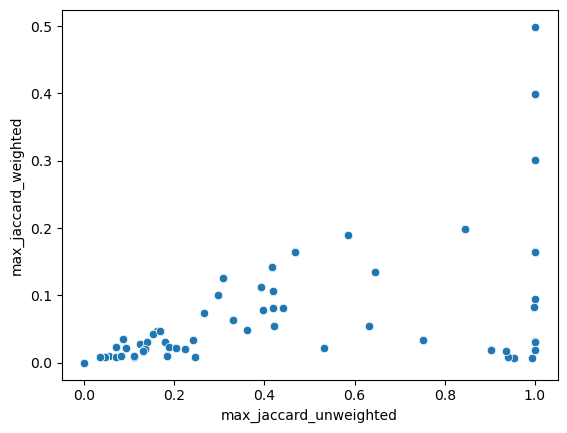

In [24]:
sns.scatterplot(cluster_df[~cluster_df['max_jaccard_weighted'].isna()], y='max_jaccard_weighted', x='max_jaccard_unweighted')

<AxesSubplot: xlabel='num_paralog', ylabel='Count'>

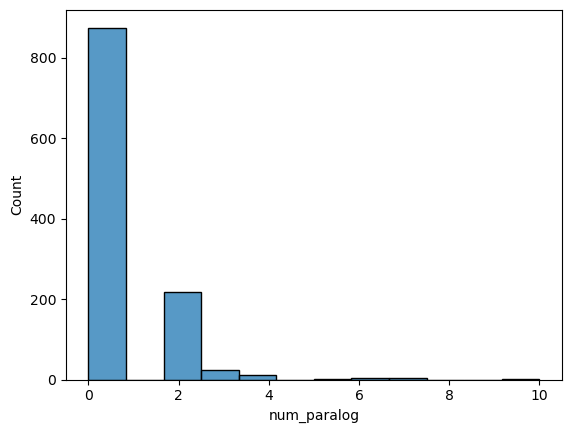

In [25]:
sns.histplot(cluster_df, x='num_paralog')

<AxesSubplot: xlabel='num_ctcf_point', ylabel='num_ctcf_peak'>

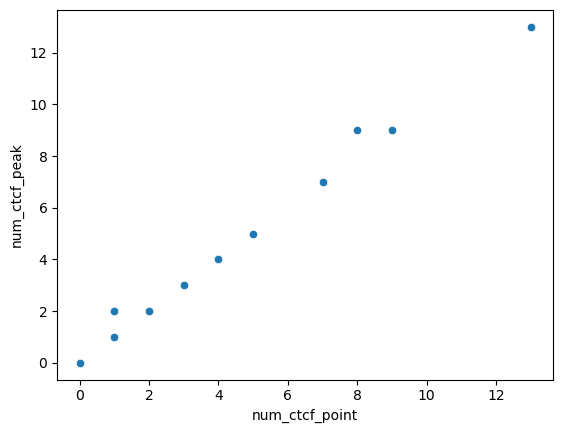

In [26]:
sns.scatterplot(cluster_df, x='num_ctcf_point', y='num_ctcf_peak')

<AxesSubplot: xlabel='has_bidirectional_promoter', ylabel='Mean_cor'>

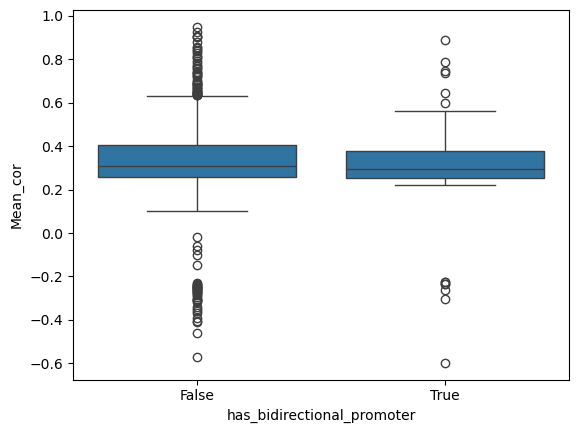

In [27]:
sns.boxplot(cluster_df, x='has_bidirectional_promoter', y='Mean_cor')


#### plot overlap between categories in the clusters

In [28]:
def generate_bool_indexed(cluster_df, column_list):
    upset_cluster_df = cluster_df.set_index(column_list[0])
    for column_name in column_list[1:]:
        upset_cluster_df.set_index(column_name, append=True, inplace=True)
    return upset_cluster_df

In [29]:
def get_deviation(cluster_df, column_list, type='count'):
    bool_indexed_clusters = generate_bool_indexed(cluster_df,column_list)
    f_observed = up.query(bool_indexed_clusters).subset_sizes

    category_totals = up.query(bool_indexed_clusters).category_totals
    inverse_category_totals = len(cluster_df) - category_totals

    f_expected = f_observed.copy()

    for idx, row in pd.DataFrame(f_expected).iterrows():
        # select the marginal totals corresponding to this index
        values_from_true_index = category_totals[list(idx)].values
        values_from_false_index = inverse_category_totals[[not i for i in idx]].values
        marginal_values = np.concatenate([values_from_false_index, values_from_true_index])
        marginal_percents = marginal_values/len(cluster_df)
        # set the value
        f_expected.loc[idx] = np.prod(marginal_percents) * len(cluster_df)

    # could do this as percent, but that emphasizs small cats
    if type=='percent':
        return (f_observed - f_expected) / f_expected * 100 
    elif type=='count':
        return (f_observed - f_expected)

In [30]:
def plot_upset_binary_categories(cluster_df, column_list, min_subset_size=5, plot_deviation=True):
    bool_indexed_clusters = generate_bool_indexed(cluster_df, column_list)
    deviation = get_deviation(cluster_df, column_list)

    bool_indexed_with_deviation = bool_indexed_clusters.join(deviation.rename('deviation'))
    
    fig = plt.figure(figsize=(8, 5))
    upset = up.UpSet(bool_indexed_with_deviation, show_counts=True, min_subset_size=min_subset_size, sort_by='cardinality')
    if plot_deviation:
        upset.add_catplot(kind='bar', value='deviation', width=.6, color='k')
    upset.plot(fig=fig)


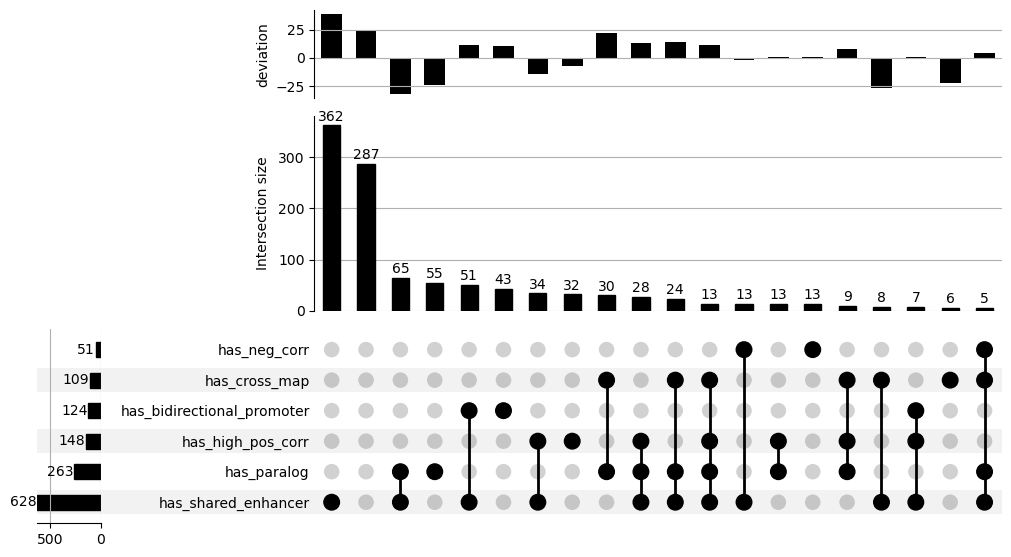

In [31]:
plot_upset_binary_categories(cluster_df, ['has_bidirectional_promoter', 'has_shared_enhancer', 'has_paralog', 'has_cross_map', 'has_neg_corr', 'has_high_pos_corr'])

## nulls for each tissue, at each cluster size

maybe subsample these to make them smaller? 

Should they be genome wide, or all the ones not in the actual clusters?

In [32]:
# add cluster size from gene-gene into cluster df
def get_cluster_size(row):
    transcript_ids = row['Transcripts'].split(',')
    cluster_gencode = gid_gencode.loc[transcript_ids]
    return  cluster_gencode['end'].max() - cluster_gencode['start'].min()

def get_cluster_tss_size(row):
    transcript_ids = row['Transcripts'].split(',')
    cluster_gencode = gid_gencode.loc[transcript_ids]
    return  cluster_gencode['tss_start'].max() - cluster_gencode['tss_start'].min()

def get_cluster_start_ids(cluster_df):
    # the first for pairs, the first and second for threes, ect
    cluster_start_ids = []
    for i in range(cluster_df['N_genes'].max()):
        out_ids = cluster_df[cluster_df['N_genes'] == i]['Transcripts'].str.split(',').str[:i-1].values
        if len(out_ids)>0:
            cluster_start_ids.append(np.concatenate(out_ids))
        else:
            cluster_start_ids.append([])
    return cluster_start_ids

def annotate_sizes(cluster_df):
    cluster_df['cluster_size'] = cluster_df.progress_apply(get_cluster_size, axis=1)
    cluster_df['cluster_tss_size'] = cluster_df.progress_apply(get_cluster_tss_size, axis=1)

In [33]:
def get_null_clusters(expressed_gencode, cluster_size, cluster_df=None):
    # sort
    expressed_gencode = expressed_gencode.sort_values(['chr', 'start', 'end'])
    # on a per chrom basis
    null_cluster_dfs = []
    for chr_id in range (1,23,1):
        chr_subset_gencode = expressed_gencode[expressed_gencode['chr'] == f'chr{chr_id}']
        transcripts = chr_subset_gencode['transcript_id'].astype(str) + ',' + chr_subset_gencode['transcript_id'].shift(-(cluster_size-1)).astype(str)
        chr_sizes = chr_subset_gencode['end'].shift(-(cluster_size-1)) - chr_subset_gencode['start']

        # trim off the blanks created from shifting
        transcripts = transcripts.iloc[:-(cluster_size-1)]
        chr_sizes = chr_sizes.iloc[:-(cluster_size-1)]

        # select those that are not already clusters
        try:
            cluster_start_ids = get_cluster_start_ids(cluster_df)
            this_cluster_size_start_ids = np.concatenate(cluster_start_ids[cluster_size:])
            in_cluster_bool = pd.Series(chr_subset_gencode['transcript_id'].iloc[:-(cluster_size-1)]).isin(this_cluster_size_start_ids).values
            null_cluster_dfs.append(pd.DataFrame({'Transcripts':transcripts[~in_cluster_bool], 'cluster_size':chr_sizes[~in_cluster_bool], 'chr':chr_id}))
        except TypeError:
            # no subselection wanted, i.e.None passed for cluster_df
            null_cluster_dfs.append(pd.DataFrame({'Transcripts':transcripts, 'cluster_size':chr_sizes, 'chr':chr_id}))

    null_df = pd.concat(null_cluster_dfs)
    null_df.reset_index(drop=True, inplace=True)
    null_df['Chromosome'] = null_df['chr']
    return null_df
    

In [34]:
# code from ben
# target has to be smaller or the two, n is length of target

def resample_dist(target, candidate_pool, n, seed=126124):   
    """Match a target distribution via weighted sampling from a candidate pool
    Args:
        target, candidate_pool: 1D numpy arrays with values ranging from 0 to 1
        n: integer number of indices to return
    Return:
        n indices to elements candidate_pool to use for the sample
    """
    rng = np.random.default_rng(seed)
    target_prob = sp.stats.gaussian_kde(target)
    candidate_prob = sp.stats.gaussian_kde(candidate_pool)

    bins = np.arange(0, 1, 0.0001)
    sampling_weight = target_prob(bins) / candidate_prob(bins)
    pool_bins = np.searchsorted(bins, candidate_pool) - 1
    pool_probability = sampling_weight[pool_bins]/sampling_weight[pool_bins].sum()

    return rng.choice(candidate_pool.size, size=n, replace=True, p=pool_probability)


def get_resamp_null_cluster(null_df, cluster_df, plot=False, number_null = 5000):
    # note that cluster_df should be resticted only to clusters with a matching number of transcripts already

    join_df = pd.concat([cluster_df, null_df], keys=['cluster', 'null'], names=['is_cluster', 'id'])
    if plot:
        # size distribution before
        sns.kdeplot(join_df.reset_index(), x='cluster_tss_size', hue='is_cluster', bw_adjust=.3, common_norm=False, log_scale=(10,None))
        plt.title('Distance distribution before resampling')
        plt.show()

    # add a normalized cluster size column to resample on
    cluster_df['normed_log_size'] = np.log10(cluster_df['cluster_tss_size'])/np.log10(join_df['cluster_tss_size'].max())
    null_df['normed_log_size'] = np.log10(null_df['cluster_tss_size'])/np.log10(join_df['cluster_tss_size'].max())

    # resample to match distance
    resamp_idxs = resample_dist(cluster_df['normed_log_size'], null_df['normed_log_size'], n=number_null)
    resamp_null_df = null_df.reset_index().iloc[resamp_idxs]

    if plot:
        # size distribution after resampling
        join_df = pd.concat([cluster_df, resamp_null_df], keys=['cluster', 'null'], names=['is_cluster', 'id'])
        sns.kdeplot(join_df, x='cluster_tss_size', hue='is_cluster', bw_adjust=.3, common_norm=False, log_scale=(10,None))
        plt.title('Distance distribution after resampling')
        plt.show()

    return resamp_null_df
        

In [35]:
#null_pairs_genome = get_null_clusters(expressed_gencode, 2, cluster_df=None).sample(5000)
#add_annotations(null_pairs_genome)


In [36]:
null_pairs_exclude_clusters = get_null_clusters(expressed_gencode, 2, cluster_df=cluster_df).sample(5000)
add_annotations(null_pairs_exclude_clusters)

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

/local/scratch/klawren/slrmtmp.44046572/ipykernel_25073/3561402268.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  enhancer_list['ABC.Score_min'] = enhancer_list['ABC.Score']
/local/scratch/klawren/slrmtmp.44046572/ipykernel_25073/3561402268.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  enhancer_list['ABC.Score_min'] = enhancer_list['ABC.Score']
/local/scratch/klawren/slrmtmp.44046572/ipykernel_25073/3561402268.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

/local/scratch/klawren/slrmtmp.44046572/ipykernel_25073/4184566315.py:8: RuntimeWarning: Mean of empty slice.
  cluster_df.loc[idx, 'Mean_neg_cor'] = cluster_corr[cluster_corr<0].mean()
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/local/scratch/klawren/slrmtmp.44046572/ipykernel_25073/4184566315.py:8: RuntimeWarning: Mean of empty slice.
  cluster_df.loc[idx, 'Mean_neg_cor'] = cluster_corr[cluster_corr<0].mean()
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/local/scratch/klawren/slrmtmp.44046572/ipykernel_25073/4184566315.py:8: RuntimeWarning: Mean of empty slice.
  cluster_df.loc[idx, 'Mean_neg_cor'] = cluster_corr[cluster_corr<0].mean()
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.

In [37]:
#annotate_sizes(cluster_df)
#null_pairs_genome_dist_matched = get_resamp_null_cluster(null_pairs_exclude_clusters, cluster_df[cluster_df['N_genes']==2], plot=True)
#add_annotations(null_pairs_genome_dist_matched)


## plotting functions

#### look at distributions of varis in cluster vs null df 

In [38]:
joined_df = pd.concat([cluster_df[cluster_df['N_genes']==2], null_pairs_exclude_clusters], keys=['cluster', 'null'], names=['type', 'idx'])

<AxesSubplot: xlabel='num_shared_go_any', ylabel='Density'>

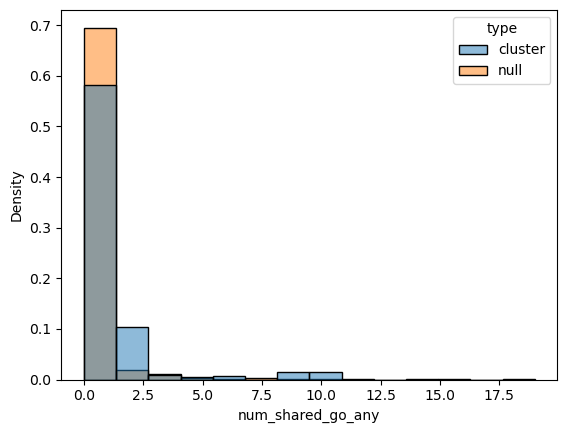

In [39]:
sns.histplot(data=joined_df, hue='type', x='num_shared_go_any', stat='density', common_norm=False)

<AxesSubplot: xlabel='num_ctcf_peak', ylabel='Density'>

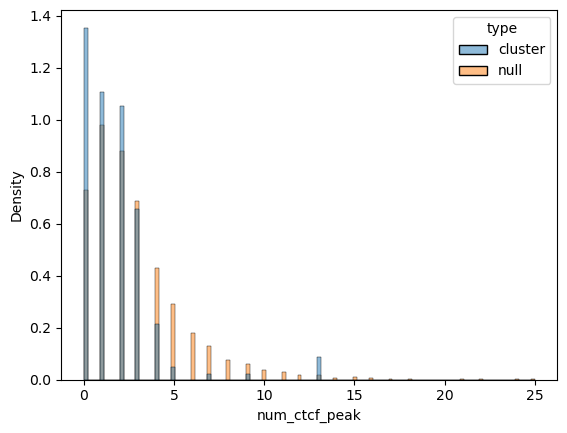

In [40]:
sns.histplot(data=joined_df, hue='type', x='num_ctcf_peak', stat='density', common_norm=False)

<AxesSubplot: xlabel='max_jaccard_unweighted', ylabel='Density'>

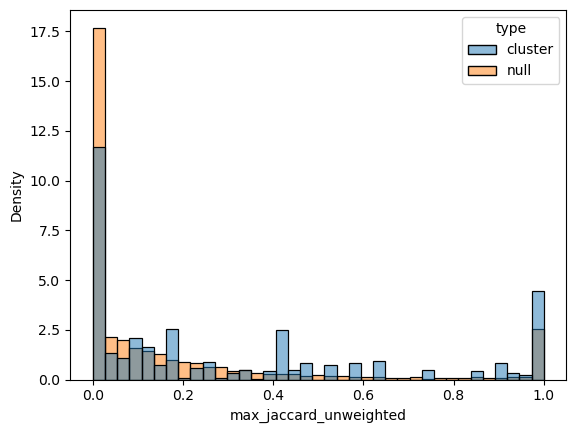

In [41]:
sns.histplot(data=joined_df[~joined_df['max_jaccard_unweighted'].isna()], hue='type', x='max_jaccard_unweighted', stat='density', common_norm=False)

<AxesSubplot: xlabel='max_jaccard_weighted', ylabel='Density'>

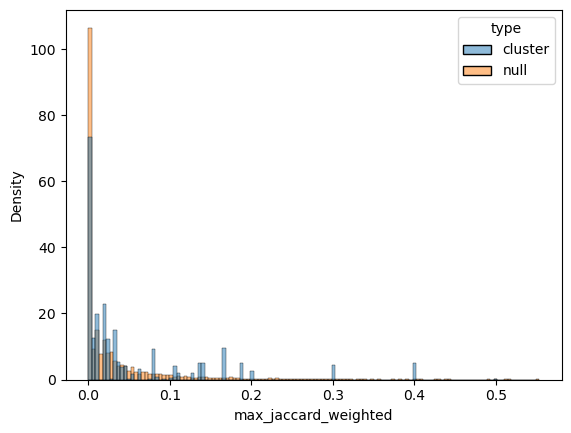

In [42]:
sns.histplot(data=joined_df[~joined_df['max_jaccard_weighted'].isna()], hue='type', x='max_jaccard_weighted', stat='density', common_norm=False)

<AxesSubplot: xlabel='num_strong_enhancers', ylabel='Density'>

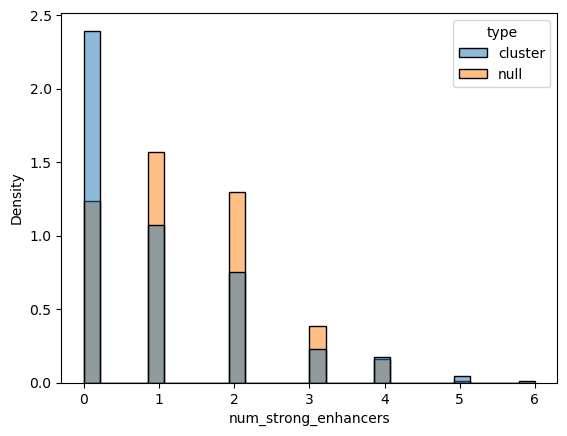

In [43]:
sns.histplot(data=joined_df, hue='type', x='num_strong_enhancers', stat='density', common_norm=False)

<AxesSubplot: xlabel='num_enhancers', ylabel='Density'>

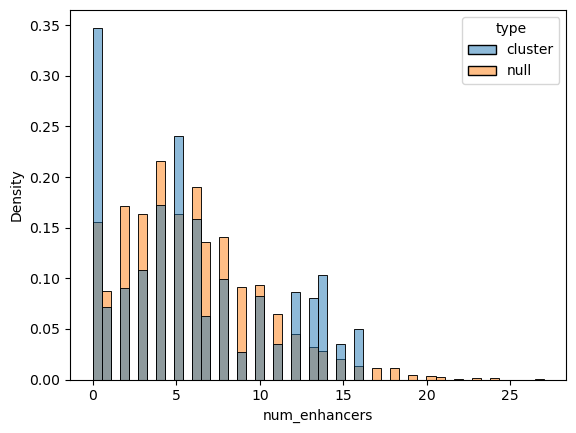

In [44]:
sns.histplot(data=joined_df, hue='type', x='num_enhancers', stat='density', common_norm=False)

<AxesSubplot: xlabel='num_shared_enhancers', ylabel='Density'>

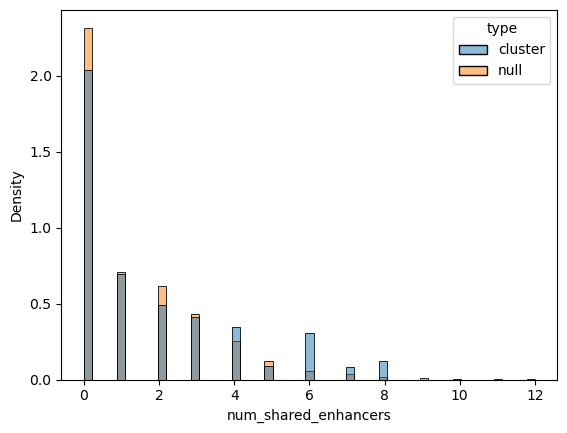

In [45]:
sns.histplot(data=joined_df, hue='type', x='num_shared_enhancers', stat='density', common_norm=False)

<AxesSubplot: xlabel='cluster_size', ylabel='Density'>

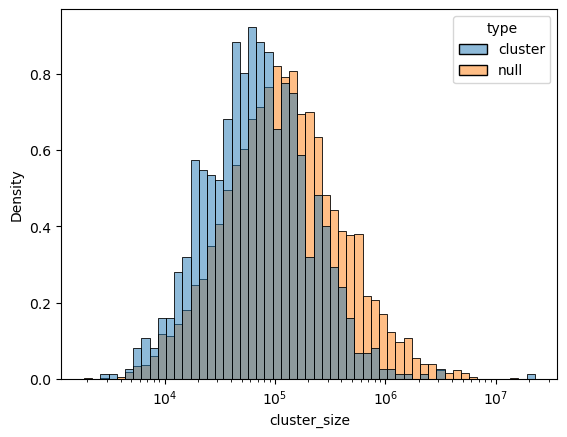

In [46]:
sns.histplot(data=joined_df, hue='type', x='cluster_size', stat='density', log_scale=True, common_norm=False)

<AxesSubplot: xlabel='cluster_tss_size', ylabel='Density'>

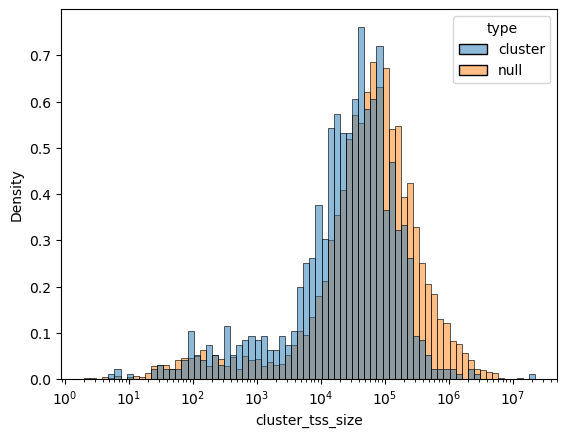

In [47]:
sns.histplot(data=joined_df, hue='type', x='cluster_tss_size', stat='density', log_scale=True, common_norm=False)

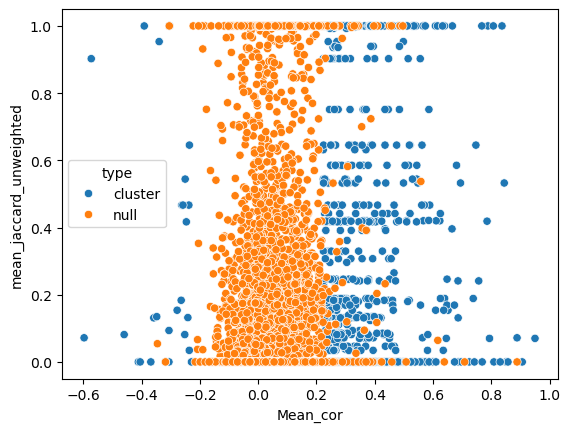

<AxesSubplot: xlabel='Mean_cor', ylabel='mean_jaccard_weighted'>

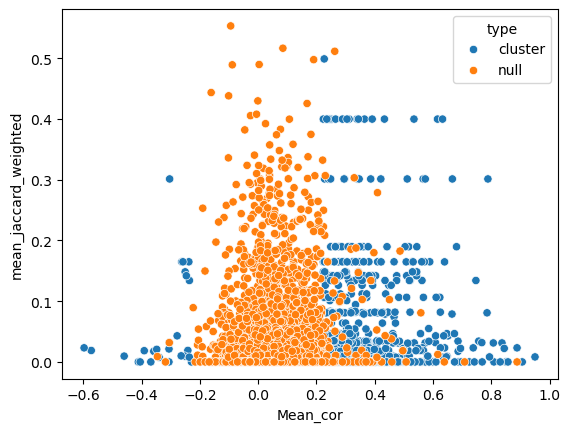

In [48]:
sns.scatterplot(joined_df[~joined_df['mean_jaccard_unweighted'].isna()], x='Mean_cor', y='mean_jaccard_unweighted', hue='type')
plt.show()
sns.scatterplot(joined_df[~joined_df['mean_jaccard_weighted'].isna()], x='Mean_cor', y='mean_jaccard_weighted', hue='type')

In [49]:
stats.pearsonr(joined_df[~joined_df['mean_jaccard_unweighted'].isna()]['mean_jaccard_unweighted'], joined_df[~joined_df['mean_jaccard_unweighted'].isna()]['Mean_cor'])

PearsonRResult(statistic=0.1568490031100555, pvalue=4.820477095246403e-31)

### log odds

In [50]:
# plot odds ratios

def get_odds_ratio(contingency_table, verb=0):
    # One-sided Fisher's exact test
    odds_ratio, p_value = stats.fisher_exact(contingency_table)
    if verb > 0:
        print("Odds Ratio:", odds_ratio)
        print("P-value:", p_value)

    # Compute 95% confidence interval for odds ratio
    a, b, c, d = contingency_table.flatten()
    SE = np.sqrt(1/a + 1/b + 1/c + 1/d)
    if odds_ratio==0:
        lcb=0
        ucb=0
    else:
        lcb = math.exp(math.log(odds_ratio) - 1.96*SE)  # lower confidence bound
        ucb = math.exp(math.log(odds_ratio) + 1.96*SE)  # upper confidence bound
    if verb > 0:
        print(f"CI: [{lcb}, {ucb}]")

    return p_value, odds_ratio, lcb, ucb

def get_contingency_table(cluster_df, null_df, column_name):
    num_cluster = sum(cluster_df[column_name])
    num_null = sum(null_df[column_name])
    # Build contingency table
    # [[yes clusters, no clusters] [yes null, no null]]
    contingency_table = np.array([[num_cluster, len(cluster_df)-num_cluster],[num_null, len(null_df)-num_null]])
    return contingency_table

def get_log_odds(cluster_df, null_df, column_list):
    log_odds_df = []
    for column_name in column_list:
        p_value, odds_ratio, lcb, ucb = get_odds_ratio(get_contingency_table(cluster_df, null_df, column_name))
        log_odds_df.append(pd.Series({'p_value': p_value,
                'odds_ratio':odds_ratio,
                'lower_cb':lcb,
                'upper_cb':ucb,
                'lower_cb_diff': odds_ratio - lcb,
                'upper_cb_diff': ucb - odds_ratio,
                'col':column_name}))
    return pd.DataFrame(log_odds_df)


# percent belonging to category
def get_frac(column_name, df):
    return sum(df[column_name])/len(df)

In [123]:
def plot_log_odds(cluster_df, null_df, column_list):
    log_odds_df = get_log_odds(cluster_df,null_df, column_list)

    log_odds_df['frac_cluster'] = log_odds_df['col'].apply(get_frac, args=(cluster_df,))
    log_odds_df['frac_null'] = log_odds_df['col'].apply(get_frac, args=(null_df,))

    fig, axes = plt.subplots(1, 2, figsize=(12,9))

    # log odds plot
    axes[0].errorbar(y=log_odds_df['col'], x=log_odds_df['odds_ratio'], xerr=log_odds_df[['lower_cb_diff', 'upper_cb_diff']].values.transpose(), fmt="o")
    axes[0].axvline(1, color='k', linestyle='--')
    axes[0].set_xlabel('Log odds')

    for idx,row in log_odds_df.iterrows():
        axes[0].annotate('OR = {:.2f}, p={:.1E}'.format(row['odds_ratio'], row['p_value']), (row['odds_ratio'], idx+.15))
        #axes[0].annotate('log odds={:.1f}'.format(np.log(row['odds_ratio'])), (row['odds_ratio'], idx-.3))


    # fraction plot
    sns.barplot(data=log_odds_df, x='frac_cluster', y='col', ax=axes[1])
    axes[1].set_yticklabels([])
    axes[1].set_ylabel('')
    axes[1].set_xlabel('Fraction in category')

    # make the labels match in order and position
    axes[1].invert_yaxis()
    axes[0].set_ylim(axes[1].get_ylim())

    # make it a log odds
    axes[0].set_xscale(u'log')

    return axes

array([<AxesSubplot: xlabel='Log odds'>,
       <AxesSubplot: xlabel='Fraction in category'>], dtype=object)

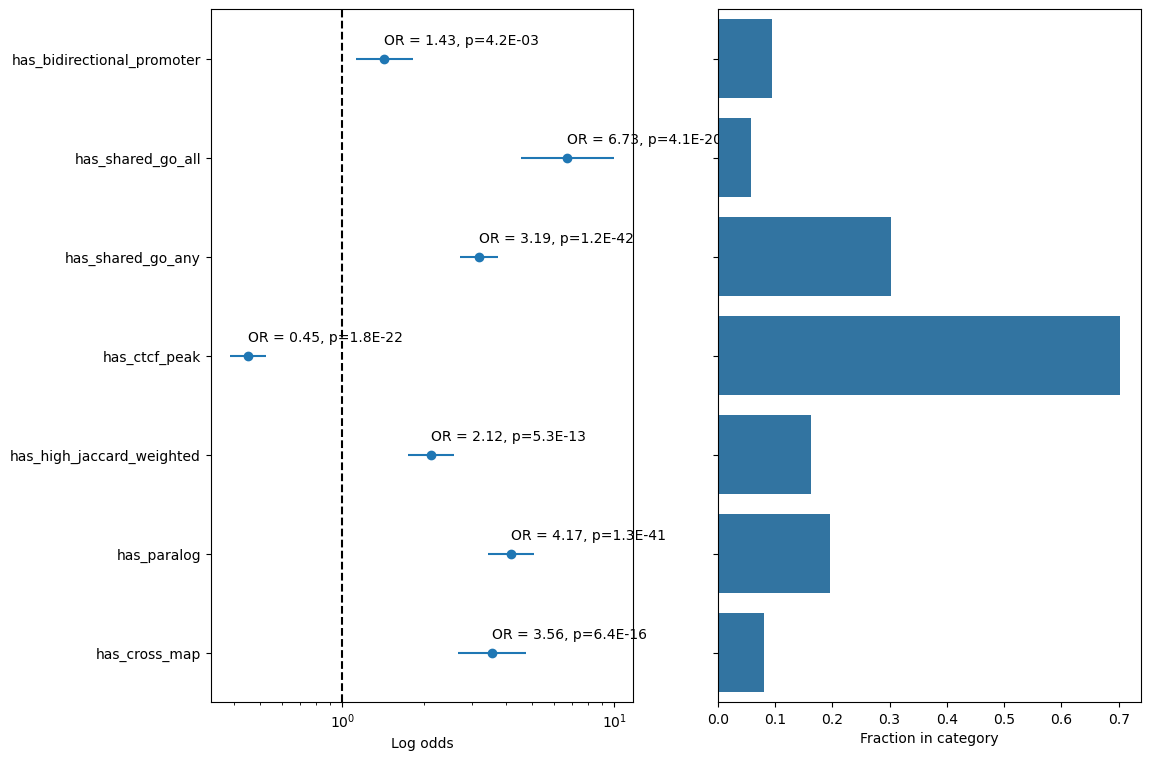

In [124]:
plot_log_odds(cluster_df[cluster_df['N_genes']==2], null_pairs_exclude_clusters, ['has_cross_map',
                                                                        'has_paralog', 
                                                                        #'has_high_jaccard_unweighted', 
                                                                        'has_high_jaccard_weighted', 
                                                                        #'has_shared_enhancer', 
                                                                        'has_ctcf_peak',
                                                                        #'has_complexes', 
                                                                        'has_shared_go_any', 
                                                                        'has_shared_go_all', 
                                                                        'has_bidirectional_promoter'])

/local/scratch/klawren/slrmtmp.44046572/ipykernel_57432/3080165456.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  SE = np.sqrt(1/a + 1/b + 1/c + 1/d)


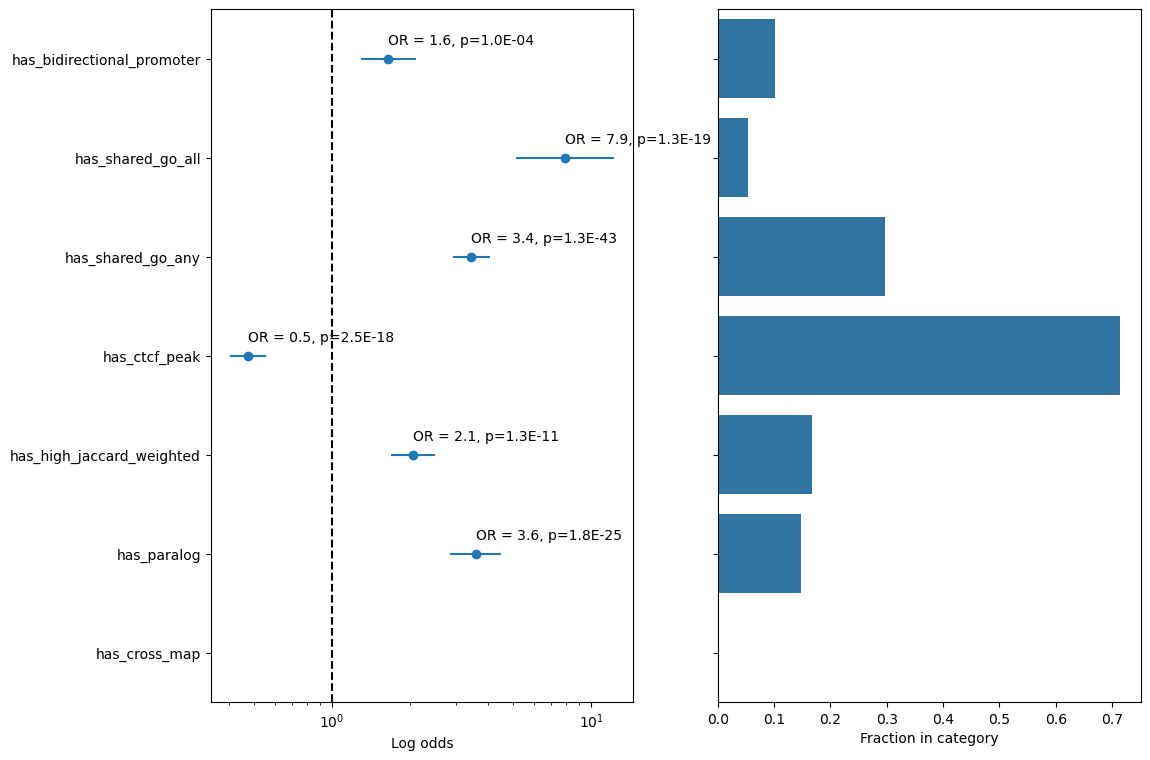

In [112]:
axes = plot_log_odds(cluster_df[(cluster_df['N_genes']==2)&(cluster_df['has_cross_map']==False)], null_pairs_exclude_clusters[null_pairs_exclude_clusters['has_cross_map']==False], ['has_cross_map',
                                                                        'has_paralog', 
                                                                        #'has_high_jaccard_unweighted', 
                                                                        'has_high_jaccard_weighted', 
                                                                        #'has_shared_enhancer', 
                                                                        'has_ctcf_peak',
                                                                        #'has_complexes', 
                                                                        'has_shared_go_any', 
                                                                        'has_shared_go_all', 
                                                                        'has_bidirectional_promoter'])
#axes[0].set_title('Excluding cross mappable genes')

In [ ]:
axes = plot_log_odds(cluster_df[cluster_df['N_genes']==2], null_pairs_genome_dist_matched, ['has_bidirectional_promoter', 'has_shared_enhancer', 'has_shared_strong_enhancer', 'has_shared_very_strong_enhancer', 'has_paralog', 'has_cross_map', 'has_shared_go_any', 'has_shared_go_all'])
axes[0].set_title('Distance matched')

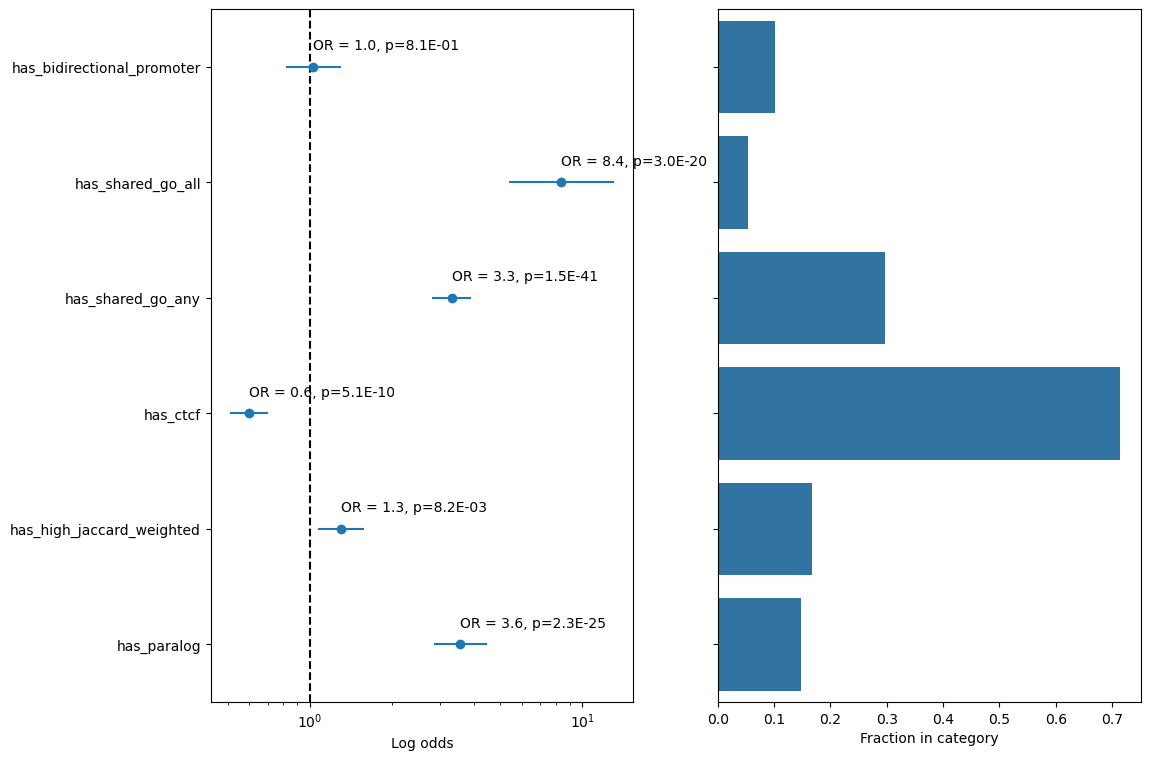

In [242]:
axes = plot_log_odds(cluster_df[(cluster_df['N_genes']==2)&(cluster_df['has_cross_map']==False)], null_pairs_genome_dist_matched[(null_pairs_genome_dist_matched['has_cross_map']==False)], [
                                                                        #'has_cross_map',
                                                                        'has_paralog', 
                                                                        #'has_high_jaccard_unweighted', 
                                                                        'has_high_jaccard_weighted', 
                                                                        #'has_shared_enhancer', 
                                                                        'has_ctcf',
                                                                        #'has_complexes', 
                                                                        'has_shared_go_any', 
                                                                        'has_shared_go_all', 
                                                                        'has_bidirectional_promoter'])
#axes[0].set_title('Distance matched, excluding cross mapped')

In [ ]:
# try with 3 gene clusters

null_threes_genome = get_null_clusters(expressed_gencode, 3, cluster_df=None)

# to make this a bit quicker
null_threes_genome = null_threes_genome
add_annotations(null_threes_genome)

In [ ]:
plot_log_odds(cluster_df[cluster_df['N_genes']==3], null_threes_genome, ['has_bidirectional_promoter', 'has_shared_enhancer', 'has_shared_strong_enhancer', 'has_paralog', 'has_cross_map', 'has_shared_go_any', 'has_shared_go_all'])

#### plot for continuous vars

using the number of things for the continuous variables
* num_ctcf_peak
* mean_jaccard_weighted
* log cluster_tss_size
* num_shared_go_any


binary vars (for pairs)
* num_cross_map
* num_paralog
* num_bidirectional_promoter
* num_shared_go_all

In [54]:
import statsmodels.api as sm

In [90]:
# balanced classes? not sure if this matters
#joined_df = pd.concat([cluster_df[cluster_df['N_genes']==2], null_pairs_exclude_clusters.sample(sum(cluster_df['N_genes']==2))], keys=['cluster', 'null'], names=['type', 'idx'])
joined_df = pd.concat([cluster_df[cluster_df['N_genes']==2], null_pairs_exclude_clusters], keys=['cluster', 'null'], names=['type', 'idx'])

In [91]:
joined_df['log_size'] = np.log10(joined_df['cluster_tss_size'])

In [138]:
x = joined_df[['log_size', 'has_ctcf_peak']].astype(int)
y = joined_df.reset_index()['type'].values == 'cluster'

In [139]:
#X = mydata[['gre', 'gpa', 'rank']]
#y = mydata['admit']

x_with_constant = sm.add_constant(x) # Add intercept term

logit_model = sm.Logit(y, x_with_constant)
result = logit_model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.438757
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 6007
Model:                          Logit   Df Residuals:                     6004
Method:                           MLE   Df Model:                            2
Date:                Tue, 13 Aug 2024   Pseudo R-squ.:                 0.02956
Time:                        17:05:27   Log-Likelihood:                -2635.6
converged:                       True   LL-Null:                       -2715.9
Covariance Type:            nonrobust   LLR p-value:                 1.372e-35
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0381      0.140      0.272      0.786      -0.236       0.313
log_size         -0.

In [141]:
# Obtain the coefficients and their standard errors
coefficients = result.params
conf_int = result.conf_int()

# Calculate the odds ratios
odds_ratios = np.exp(coefficients)

# Calculate the confidence intervals for odds ratios
odds_ratios_ci = np.exp(conf_int)

print("Odds Ratios:")
print(odds_ratios)

print("95% Confidence Intervals for Odds Ratios:")
print(odds_ratios_ci)

Odds Ratios:
const            1.038807
log_size         0.756495
has_ctcf_peak    0.509630
dtype: float64
95% Confidence Intervals for Odds Ratios:
                      0         1
const          0.789427  1.366966
log_size       0.707913  0.808410
has_ctcf_peak  0.434995  0.597070


In [126]:
reg.coef_

array([[-0.22344814]])

## combining over all tissues

In [ ]:
load_all_tissues = True

In [ ]:
sub_tissue_ids = tissue_ids[:5]

In [ ]:
# load in cluster data for a single tissue
cluster_df = pd.read_csv(f'{prefix}/{clusters_dir}/{my_tissue_id}_clusters_all_chr.csv', index_col=0)

# load in cluster data for all tissues
if load_all_tissues:
    all_tissue_cluster_dfs={}
    for tissue_id in sub_tissue_ids: 
        all_tissue_cluster_dfs[tissue_id] = pd.read_csv(f'{prefix}/{clusters_dir}/{tissue_id}_clusters_all_chr.csv', index_col=0)

# load in expression data (so we only compare to pairs of genes also expressed in this tissue)
# load in gene expression data
expression_df = pd.read_csv(f'{prefix}/{expression_dir}/{my_tissue_id}.v8.normalized_expression.bed', sep='\t')

# load in expression data for all tissues 
if load_all_tissues:
    all_tissue_expression_dfs={}
    for tissue_id in sub_tissue_ids: 
        all_tissue_expression_dfs[tissue_id] = pd.read_csv(f'{prefix}/{expression_dir}/{tissue_id}.v8.normalized_expression.bed', sep='\t')

# expressed genes in sample tissue
expressed_gencode = full_gencode[full_gencode['transcript_id'].isin(expression_df['gene_id'])]
expressed_gencode = expressed_gencode.sort_values(['chr', 'start', 'end'])


# expressed genes in all tissues
if load_all_tissues:
    all_tissue_expressed_gencode_dfs={}
    for tissue_id in sub_tissue_ids: 
        expressed_gencode = full_gencode[full_gencode['transcript_id'].isin(all_tissue_expression_dfs[tissue_id]['gene_id'])]
        expressed_gencode = expressed_gencode.sort_values(['chr', 'start', 'end'])
        all_tissue_expressed_gencode_dfs[tissue_id] = expressed_gencode

In [ ]:
all_tissue_null_distance_matched = {}
all_tissue_nulls = {}

for tissue_id in sub_tissue_ids: 
    # annotate all the clusters
    add_annotations(all_tissue_cluster_dfs[tissue_id])

    # create all the nulls
    all_tissue_nulls[tissue_id] = get_null_clusters(all_tissue_expressed_gencode_dfs[tissue_id], 2, cluster_df=all_tissue_cluster_dfs[tissue_id])
    annotate_sizes(all_tissue_cluster_dfs[tissue_id])
    add_annotations(all_tissue_nulls[tissue_id])
    all_tissue_null_distance_matched[tissue_id] = get_resamp_null_cluster(all_tissue_nulls[tissue_id], all_tissue_cluster_dfs[tissue_id][all_tissue_cluster_dfs[tissue_id]['N_genes']==2], plot=True)
    plt.show()
    add_annotations(all_tissue_null_distance_matched[tissue_id])


    # write out annotated clusters and nulls for future use
    all_tissue_cluster_dfs[tissue_id].to_csv(f'{prefix}/{clusters_dir}/{tissue_id}_clusters_annotated.csv', sep='\t')
    all_tissue_nulls[tissue_id].to_csv(f'{prefix}/{clusters_dir}/{tissue_id}_clusters_null.csv', sep='\t', index=None)
    all_tissue_null_distance_matched[tissue_id].to_csv(f'{prefix}/{clusters_dir}/{tissue_id}_clusters_null_distance_matched.csv', sep='\t', index=None)



    # make a plot for this tissue

    axes = plot_log_odds(all_tissue_cluster_dfs[tissue_id][(all_tissue_cluster_dfs[tissue_id]['N_genes']==2)&(all_tissue_cluster_dfs[tissue_id]['has_cross_map']==False)], 
                         all_tissue_null_distance_matched[tissue_id][(all_tissue_null_distance_matched[tissue_id]['has_cross_map']==False)], 
                         ['has_bidirectional_promoter', 'has_shared_strong_enhancer', 'has_shared_very_strong_enhancer', 'has_paralog', 'has_shared_go_any', 'has_shared_go_all'])
    axes[0].set_title(f'{tissue_id} Distance matched, excluding cross mapped')
    plt.show()


In [ ]:
# load in the annotated dfs
all_tissue_null_distance_matched = {}
all_tissue_nulls = {}
all_tissue_cluster_dfs = {}

for tissue_id in sub_tissue_ids: 

    # read in annotated clusters and nulls
    all_tissue_cluster_dfs[tissue_id] = pd.read_csv(f'{prefix}/{clusters_dir}/{tissue_id}_clusters_annotated.csv', sep='\t')
    all_tissue_nulls[tissue_id] = pd.read_csv(f'{prefix}/{clusters_dir}/{tissue_id}_clusters_null.csv', sep='\t')
    all_tissue_null_distance_matched[tissue_id] = pd.read_csv(f'{prefix}/{clusters_dir}/{tissue_id}_clusters_null_distance_matched.csv', sep='\t')



    # make a plot for this tissue


    axes = plot_log_odds(all_tissue_cluster_dfs[tissue_id][(all_tissue_cluster_dfs[tissue_id]['N_genes']==2)&(all_tissue_cluster_dfs[tissue_id]['has_cross_map']==False)], 
                         all_tissue_nulls[tissue_id][(all_tissue_nulls[tissue_id]['has_cross_map']==False)], 
                         ['has_bidirectional_promoter', 'has_shared_strong_enhancer', 'has_shared_very_strong_enhancer', 'has_paralog', 'has_shared_go_any', 'has_shared_go_all'])
    axes[0].set_title(f'{tissue_id} Not distance matched, excluding cross mapped')

    axes = plot_log_odds(all_tissue_cluster_dfs[tissue_id][(all_tissue_cluster_dfs[tissue_id]['N_genes']==2)&(all_tissue_cluster_dfs[tissue_id]['has_cross_map']==False)], 
                         all_tissue_null_distance_matched[tissue_id][(all_tissue_null_distance_matched[tissue_id]['has_cross_map']==False)], 
                         ['has_bidirectional_promoter', 'has_shared_strong_enhancer', 'has_shared_very_strong_enhancer', 'has_paralog', 'has_shared_go_any', 'has_shared_go_all'])
    axes[0].set_title(f'{tissue_id} Distance matched, excluding cross mapped')
    plt.show()


In [ ]:
# combine the null and clusters

full_cluster_df = pd.concat([all_tissue_cluster_dfs[t] for t in sub_tissue_ids])
full_null_df = pd.concat([all_tissue_nulls[t] for t in sub_tissue_ids])
full_null_distance_matched_df = pd.concat([all_tissue_null_distance_matched[t] for t in sub_tissue_ids])


axes = plot_log_odds(full_cluster_df[(full_cluster_df['N_genes']==2)&(full_cluster_df['has_cross_map']==False)], 
                         full_null_df[full_null_df['has_cross_map']==False], 
                         ['has_bidirectional_promoter', 'has_shared_strong_enhancer', 'has_paralog', 'has_shared_go_any', 'has_shared_go_all'])
axes[0].set_title(f'Combined tissues excluding cross-mapped')


axes = plot_log_odds(full_cluster_df[(full_cluster_df['N_genes']==2)&(full_cluster_df['has_cross_map']==False)], 
                         full_null_distance_matched_df[full_null_distance_matched_df['has_cross_map']==False], 
                         ['has_bidirectional_promoter', 'has_shared_strong_enhancer', 'has_paralog', 'has_shared_go_any', 'has_shared_go_all'])
axes[0].set_title(f'Combined tissues distance matched, excluding cross-mapped')
plt.show()

In [ ]:
axes = plot_log_odds(full_cluster_df[(full_cluster_df['has_cross_map']==False)], 
                         full_null_distance_matched_df[full_null_distance_matched_df['has_cross_map']==False], 
                         ['has_bidirectional_promoter', 'has_shared_strong_enhancer', 'has_paralog', 'has_shared_go_any', 'has_shared_go_all'])
axes[0].set_title(f'Combined tissues excluding cross-mapped')

### distance and n genes matched nulls?